In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Prepare Data

In [2]:
cloud_cover = pd.read_csv('Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv',skipinitialspace = True)
cloud_cover.isnull().sum()

Year          0
Month         0
Day           0
Hour          0
Minute        0
Second        0
CloudCover    0
dtype: int64

In [3]:
cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)     
cloud_cover

,CloudCover,Date,Time
0,0.990,2021-11-16,11:15
1,0.989,2021-11-16,11:16
2,0.989,2021-11-16,11:16
3,0.988,2021-11-16,11:17
4,0.988,2021-11-16,11:17
...,...,...,...
22021,0.168,2021-12-16,13:58
22022,0.169,2021-12-16,13:59
22023,0.147,2021-12-16,14:00
22024,0.145,2021-12-16,14:01


In [4]:
cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
cloud_cover

,cloud_cover,DateTime
0,0.990000,2021-11-16 11:15:00
1,0.989000,2021-11-16 11:16:00
2,0.987667,2021-11-16 11:17:00
3,0.987000,2021-11-16 11:18:00
4,0.987000,2021-11-16 11:19:00
...,...,...
15056,0.168000,2021-12-16 13:58:00
15057,0.169000,2021-12-16 13:59:00
15058,0.147000,2021-12-16 14:00:00
15059,0.145000,2021-12-16 14:01:00


In [5]:
cloud_cover.dropna(inplace=True)
cloud_cover

,cloud_cover,DateTime
0,0.990000,2021-11-16 11:15:00
1,0.989000,2021-11-16 11:16:00
2,0.987667,2021-11-16 11:17:00
3,0.987000,2021-11-16 11:18:00
4,0.987000,2021-11-16 11:19:00
...,...,...
15056,0.168000,2021-12-16 13:58:00
15057,0.169000,2021-12-16 13:59:00
15058,0.147000,2021-12-16 14:00:00
15059,0.145000,2021-12-16 14:01:00


In [6]:
df = cloud_cover[['DateTime', 'cloud_cover']]
df.columns = ['ds', 'y']

### Train/Test Model

In [7]:
X_train = df[df['ds'] < '2021-12-16 09:11:00']
X_test = df[df['ds'] >= '2021-12-16 09:11:00']

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train['ds'].unique()

X_train Shape (14769, 2)
X_test Shape (292, 2)


array(['2021-11-16T11:15:00.000000000', '2021-11-16T11:16:00.000000000',
       '2021-11-16T11:17:00.000000000', ...,
       '2021-12-15T16:58:00.000000000', '2021-12-15T16:59:00.000000000',
       '2021-12-16T09:10:00.000000000'], dtype='datetime64[ns]')

In [8]:
train = X_train[['ds','y']]
train1 = train[['ds','y']]
print(train1.head,train1.tail)

test = X_test[['ds','y']]
test1 = test[['ds','y']]
print(test1.head,test1.tail)
test1.set_index('ds', inplace = True)

<bound method NDFrame.head of                        ds         y
0     2021-11-16 11:15:00  0.990000
1     2021-11-16 11:16:00  0.989000
2     2021-11-16 11:17:00  0.987667
3     2021-11-16 11:18:00  0.987000
4     2021-11-16 11:19:00  0.987000
...                   ...       ...
14764 2021-12-15 16:56:00  0.304000
14765 2021-12-15 16:57:00  0.286000
14766 2021-12-15 16:58:00  0.344000
14767 2021-12-15 16:59:00  0.328000
14768 2021-12-16 09:10:00  0.111000

[14769 rows x 2 columns]> <bound method NDFrame.tail of                        ds         y
0     2021-11-16 11:15:00  0.990000
1     2021-11-16 11:16:00  0.989000
2     2021-11-16 11:17:00  0.987667
3     2021-11-16 11:18:00  0.987000
4     2021-11-16 11:19:00  0.987000
...                   ...       ...
14764 2021-12-15 16:56:00  0.304000
14765 2021-12-15 16:57:00  0.286000
14766 2021-12-15 16:58:00  0.344000
14767 2021-12-15 16:59:00  0.328000
14768 2021-12-16 09:10:00  0.111000

[14769 rows x 2 columns]>
<bound method NDFrame.

### Prepare Data for prediction 20 minutes 

In [9]:
cloud_cover.set_index('DateTime', 'cloud_cover', inplace=True)
index_20_min = pd.date_range(cloud_cover.index[-1], freq='1T', periods = 21) 
index_20_min

C:\Users\USER\AppData\Local\Temp\ipykernel_4200\247494214.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.
  cloud_cover.set_index('DateTime', 'cloud_cover', inplace=True)


DatetimeIndex(['2021-12-16 14:02:00', '2021-12-16 14:03:00',
               '2021-12-16 14:04:00', '2021-12-16 14:05:00',
               '2021-12-16 14:06:00', '2021-12-16 14:07:00',
               '2021-12-16 14:08:00', '2021-12-16 14:09:00',
               '2021-12-16 14:10:00', '2021-12-16 14:11:00',
               '2021-12-16 14:12:00', '2021-12-16 14:13:00',
               '2021-12-16 14:14:00', '2021-12-16 14:15:00',
               '2021-12-16 14:16:00', '2021-12-16 14:17:00',
               '2021-12-16 14:18:00', '2021-12-16 14:19:00',
               '2021-12-16 14:20:00', '2021-12-16 14:21:00',
               '2021-12-16 14:22:00'],
              dtype='datetime64[ns]', freq='T')

In [10]:
df_index_20_min = pd.DataFrame(index_20_min)
df_index_20_min.columns = ['ds']
df_index_20_min

,ds
0,2021-12-16 14:02:00
1,2021-12-16 14:03:00
2,2021-12-16 14:04:00
3,2021-12-16 14:05:00
4,2021-12-16 14:06:00
5,2021-12-16 14:07:00
6,2021-12-16 14:08:00
7,2021-12-16 14:09:00
8,2021-12-16 14:10:00
9,2021-12-16 14:11:00


# Time Series Forecasting with ARIMA

ARIMA(p,d,q)
- pคือจำนวนเงื่อนไขการถดถอยอัตโนมัติ
- dคือจำนวนของความแตกต่างนอกฤดูกาลที่จำเป็นสำหรับการหยุดนิ่งและ
- qคือจำนวนข้อผิดพลาดการคาดการณ์ที่ล่าช้าในสมการการทำนาย

In [11]:
model = auto_arima(df['y'],
                  trace=True,
                  suppress_warnings=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-59530.889, Time=7.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59471.608, Time=2.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-59475.842, Time=0.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-59476.560, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-59473.565, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-59522.409, Time=5.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-59521.637, Time=3.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-59517.227, Time=7.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-59530.474, Time=7.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-59480.030, Time=5.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-59518.984, Time=8.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-59517.799, Time=2.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-59529.157, Time=4.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-59532.835, Time=5.56 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15061
Model:               SARIMAX(2, 1, 4)   Log Likelihood               29776.791
Date:                Mon, 24 Oct 2022   AIC                         -59539.581
Time:                        15:15:24   BIC                         -59486.243
Sample:                             0   HQIC                        -59521.888
                              - 15061                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4281      0.186      2.299      0.021       0.063       0.793
ar.L2         -0.2698      0.180     -1.498      0.134      -0.623       0.083
ma.L1         -0.4493      0.186     -2.413      0.016      -0.814      -0.084
ma.L2          0.2225      0.181      1.229      0.219      -0.132       0.578
ma.L3          0.0304      0.011      2.719      0.007       0.008       0.052
ma.L4         -0.0510      0.011     -4.656      0.000      -0.072      -0.030
sigma2         0.0011   1.24e-06    902.359      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          34274022.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             3.15
Prob(H) (two-sided):                  0.00   Kurtosis:                       236.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
model_arima = ARIMA(train1['y'], order = (2,1,4))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                14769
Model:                 ARIMA(2, 1, 4)   Log Likelihood               29269.348
Date:                Mon, 24 Oct 2022   AIC                         -58524.695
Time:                        15:15:27   BIC                         -58471.494
Sample:                             0   HQIC                        -58507.030
                              - 14769                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4224      0.181      2.336      0.019       0.068       0.777
ar.L2         -0.2737      0.175     -1.564      0.118      -0.617       0.069
ma.L1         -0.4463      0.181     -2.468      0.014      -0.801      -0.092
ma.L2          0.2257      0.176      1.283      0.199      -0.119       0.571
ma.L3          0.0308      0.011      2.737      0.006       0.009       0.053
ma.L4         -0.0523      0.011     -4.806      0.000      -0.074      -0.031
sigma2         0.0011   1.24e-06    894.050      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          33603558.56
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             3.74
Prob(H) (two-sided):                  0.00   Kurtosis:                       236.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
start=len(train)
end=len(train)+len(test)-1
index_future_dates=pd.date_range(start='2021-12-16 09:11:00',end='2021-12-16 14:02:00', freq='1T')
pred=model_arima.predict(start=start,end=end,typ='levels')
pred.index=index_future_dates
pred = pd.DataFrame(pred)

In [21]:
pred

,predicted_mean
2021-12-16 09:11:00,0.119072
2021-12-16 09:12:00,0.129925
2021-12-16 09:13:00,0.126450
2021-12-16 09:14:00,0.133227
2021-12-16 09:15:00,0.137040
...,...
2021-12-16 13:58:00,0.135528
2021-12-16 13:59:00,0.135528
2021-12-16 14:00:00,0.135528
2021-12-16 14:01:00,0.135528


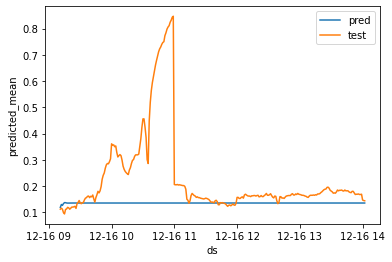

In [14]:
# pred.plot(legend=True)
sns.lineplot(x=pred.index, y = pred["predicted_mean"], label = 'pred');
sns.lineplot(x=test1.index, y = test1["y"], label = 'test');

### forecasting with 20 minutes

In [22]:
model_arima_20 = ARIMA(df['y'], order = (2,1,4))
model_arima_20 = model_arima_20.fit()
model_arima_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15061
Model:                 ARIMA(2, 1, 4)   Log Likelihood               29776.791
Date:                Mon, 24 Oct 2022   AIC                         -59539.581
Time:                        16:00:38   BIC                         -59486.243
Sample:                             0   HQIC                        -59521.888
                              - 15061                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4281      0.186      2.299      0.021       0.063       0.793
ar.L2         -0.2698      0.180     -1.498      0.134      -0.623       0.083
ma.L1         -0.4493      0.186     -2.413      0.016      -0.814      -0.084
ma.L2          0.2225      0.181      1.229      0.219      -0.132       0.578
ma.L3          0.0304      0.011      2.719      0.007       0.008       0.052
ma.L4         -0.0510      0.011     -4.656      0.000      -0.072      -0.030
sigma2         0.0011   1.24e-06    902.359      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          34274022.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             3.15
Prob(H) (two-sided):                  0.00   Kurtosis:                       236.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
index_future_dates20=pd.date_range(start='2021-12-16 14:02:00',end='2021-12-16 14:22:00', freq='1T')
pred20=model_arima_20.predict(start=len(df),end=len(df)+20,typ='levels')
pred20.index=index_future_dates20
pred20 = pd.DataFrame(pred20)
pred20

,predicted_mean
2021-12-16 14:02:00,0.143908
2021-12-16 14:03:00,0.144657
2021-12-16 14:04:00,0.145057
2021-12-16 14:05:00,0.145146
2021-12-16 14:06:00,0.145076
2021-12-16 14:07:00,0.145022
2021-12-16 14:08:00,0.145018
2021-12-16 14:09:00,0.145031
2021-12-16 14:10:00,0.145037
2021-12-16 14:11:00,0.145037


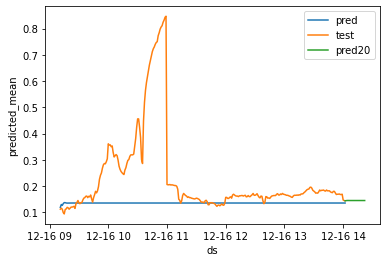

In [24]:
sns.lineplot(x=pred.index, y = pred["predicted_mean"], label = 'pred')
sns.lineplot(x=test1.index, y = test1["y"], label = 'test')
sns.lineplot(x=pred20.index, y = pred20["predicted_mean"], label = 'pred20');

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x= train1['ds'], y=train1["y"], name='Train'))
fig.add_trace(go.Scatter(mode='lines', x=pred.index, y = pred["predicted_mean"], name='forecast_prophet_predict'))
fig.add_trace(go.Scatter(mode='lines', x=test1.index, y = test1["y"], name='test'))
# fig.add_trace(go.Scatter(mode='lines', x=forecast_pro['ds'], y = forecast_pro["yhat"],  name='forecast_prophet_predict_compare_test'))
fig.add_trace(go.Scatter(mode='lines', x=pred20.index, y =pred20["predicted_mean"],  name='forecast_prophet_predict_prediction_20_ms'))

fig.update_layout(
    autosize=True,
    height=600,
    title="Prophet Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1h",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="12h",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="1d",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

# Evaluating forecast accuracy

น้อยดี

In [26]:
prophet_mse_error = mean_squared_error(test1["y"], pred["predicted_mean"], squared=True)
prophet_rmse_error = mean_squared_error(test1["y"], pred["predicted_mean"], squared=False)
prophet_mae_error = mean_absolute_error(test1["y"], pred["predicted_mean"])

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMAE: {prophet_mae_error}')

MSE Error: 0.03452768756887149
RMSE Error: 0.18581627369224551
MAE: 0.09586626625151146


In [27]:
prophet_r2 = r2_score(test1["y"], pred["predicted_mean"])
print(f'r2_score: {prophet_r2}')

r2_score: -0.33288473658803297
